In [238]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [239]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [240]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [241]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///./Resources/hawaii.sqlite", echo=False)
conn = engine.connect()

In [242]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [243]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [244]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [245]:
first_row = session.query(measurment).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0xbfe73f9d00>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'date': '2010-01-01',
 'tobs': 65.0,
 'id': 1}

In [246]:
engine.execute('SELECT * FROM station LIMIT 5').fetchall()
first_row = session.query(station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0xbfe74052b0>,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'latitude': 21.2716,
 'elevation': 3.0,
 'station': 'USC00519397',
 'id': 1}

In [247]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [248]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [293]:
# Find the most recent date in the data set.
last_date= session.query(measurement.date).order_by(measurement.date.desc()).first()
last_date

('2017-08-23')

In [290]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.

query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Query Date: ", query_date)

Query Date:  2016-08-23


In [294]:
# Perform a query to retrieve the data and precipitation scores

data_query = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= query_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

precipitation_pd = pd.DataFrame(data_query, columns=['Date', 'Precipitation'])
precipitation_pd

# Sort the dataframe by date
precipitation_pd = precipitation_pd.sort_index(ascending=True)
precipitation_pd.head()

,Date,Precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


Text(0, 0.5, 'Inches')

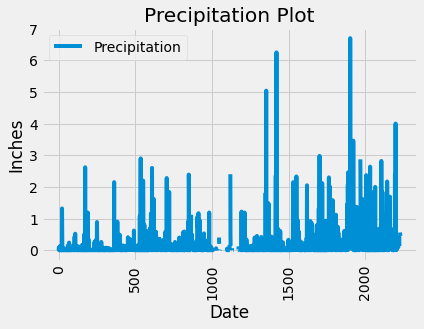

In [295]:
# Use Pandas Plotting with Matplotlib to plot the data
# Set x axis and tick locations

precipitation_pd.plot()
#plt.figure(figsize=(20,3))
#plt.bar(precipitation_pd["Date"], precipitation_pd["Precipitation"], color='b', alpha=0.5, align="edge")
plt.xticks(rotation="vertical")

# Give our chart some labels and a tile

plt.title("Precipitation Plot")
plt.xlabel("Date")
plt.ylabel("Inches")

In [259]:
plt.tight_layout()
plt.savefig("Images/avg_rain.png")
plt.show()

<Figure size 432x288 with 0 Axes>

In [264]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_pd.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [ ]:
# Design a query to calculate the total number stations in the dataset


In [ ]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.


In [ ]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


In [ ]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close session

In [ ]:
# Close Session
session.close()